In [1]:
import numpy as np
from matplotlib.pyplot import plot, grid, xlabel, ylabel, legend
import matplotlib.pyplot as plt
import scipy
from scipy import special

# Introduction

The main theoretical description was published in [JOURNAL OF RADIO ELECTRONICS](http://jre.cplire.ru/jre/oct17/6/text.pdf).

Materials were also presented in the II SCIENTIFIC FORUM OF TELECOMMUNICATIONS: THEORY AND TECHNOLOGY TTT-2017 (Kazan, November 20 - 24, 2017):

In [2]:
from IPython.core.display import HTML
HTML('<iframe src="//www.slideshare.net/slideshow/embed_code/key/I6U6pQsuqqjNO8" width="595" height="485" frameborder="0" marginwidth="0" marginheight="0" scrolling="no" style="border:1px solid #CCC; border-width:1px; margin-bottom:5px; max-width: 100%;" allowfullscreen> </iframe> <div style="margin-bottom:5px"> <strong> <a href="//www.slideshare.net/VladimirFadeev4/optical-intersatellite-links-for-cubesat-satellites" title="Optical Inter-Satellite Links for CubeSat Satellites" target="_blank">Optical Inter-Satellite Links for CubeSat Satellites</a> </strong> from <strong><a href="https://www.slideshare.net/VladimirFadeev4" target="_blank">VladimirFadeev4</a></strong> </div>')

Some formulas are corrected in the presented below matherials.

# Initialization

In [3]:
#initial parameters for optical case
R = 100*1e3  #distance between satellites in m (100 km)
Bit_rate = 1e6 #bit rate (1 Mbps)
h = 6.62607004*1e-34 # Planck constant
c = 299792458 #speed of light
wavelength_opt = 1550*1e-9 #optical wavelength
freq_opt = c/wavelength_opt #optical frequency

In [4]:
Ptx_opt = 1 #transmitter power in Watts
Ptx_opt_dBm = 10*np.log10(Ptx_opt*1e3) #transmitter power in dBm

# Receive power

In [5]:
a = np.array([i for i in range(0,50,5)])*1e-3 #diameter of the receiver (in meters)
a[0] = 1*1e-3
a_m = a*100 # for figures (in cm)
div_ang = np.array([0.2*1e-3, 0.5*1e-3, 2*1e-3, 5*1e-3, 7*1e-3]) #half of divergence angle

Receive power [[1]](https://www.researchgate.net/publication/3435855_Short-range_wireless_infrared_transmission_The_link_budget_compared_to_RF):
$$ P_{rx} = \frac{A_{rx}}{2\pi R^2} \left(1 - \frac{ln2}{ln(cos \theta_{div})}\right)P_{tx} \quad [W]$$
where $A_{rx} = \frac{d_{rx}^2 \pi}{4} $ is the receive  area (assuming the angle of incidence is equal to 0), $d_{rx}$ is the diameter of the receiver, $R$ is the distance between satellites, $\theta_{div}$ is the half of divergence angle and $P_{tx}$ is the transmitt power.

In [6]:
Prx_opt_dBm = np.zeros((len(div_ang), len(a)))
Prx_opt = np.zeros((len(div_ang), len(a)))
Pathloss_dBm = np.zeros((len(div_ang), len(a)))
Pathloss = np.zeros((len(div_ang), len(a)))
Arx_m2 = (np.pi/4)*(a**2)

for f, dvangl in enumerate(div_ang): 
    #received power
    Prx_opt[f,:] = (Ptx_opt*Arx_m2)/ (2*np.pi*(R**2))*(1-(np.log(2)/np.log(np.cos(dvangl))));
    Prx_opt_dBm[f,:] = 10*np.log10(Prx_opt[f,:]*1e3);
    #path loss
    Pathloss[f,:] = (Arx_m2)/(2*np.pi*(R**2))*(1-(np.log(2)/np.log(np.cos(dvangl))));
    Pathloss_dBm[f,:] = 10*np.log10(Pathloss[f,:]*1000);

# REQUIRED received power

## Quantum limits for required receiver sensitivity

Photon energy:

$$ E = hf \quad \left[m^2 kg / s^2\right]$$

where $h$ = 6.62607004e-34 $m^2 kg / s$ is the Planck constant and $f$ is the optical frequency (Hz).

Requiered  energy (minimum energy on the receiver side to detect anything per bit):

$$ E_{req, Q} = N_{ph}hf \quad \left[m^2 kg / s^2\right]$$

where $N_{ph}$ is the average nuber of photons that neded to detect 1 bit of information.

Theoretical energy for the optical pulse: 

In [7]:
E_theor = 10*h*freq_opt 

More realistic energy for optical pulse (APD diode):

In [8]:
E_real_APD = 1000*h*freq_opt 

More realistic energy for optical pulse (PIN diode):

In [9]:
E_real_PIN = 10000*h*freq_opt 

Required (minimum) receive power (maximum sensitivity):

$$ P_{req, Q} = 10\log_{10}\left(\frac{E_{req, Q}B}{10^{-3}}\right) = 10\log_{10}\left(\frac{E_{req, Q}R_b}{10^{-3}}\right) \quad[dBm]$$

where $B$ is the channel bandwidth and $R_b$ is the bit rate.

In [10]:
P_req_theor = 10*np.log10(E_theor*Bit_rate*1000)
P_req_real_APD = 10*np.log10(E_real_APD*Bit_rate*1000)
P_req_real_PIN = 10*np.log10(E_real_PIN*Bit_rate*1000)

## Bounds in dependence on error propability (OOK)

Error probability (BER) of the On-off keying (OOK) [2]:

$$P_b = \frac{1}{2}ercf\left(\sqrt{\frac{SNR}{2}}\right) = \frac{1}{2}ercf\left(\sqrt{\frac{P_{req}^2\gamma^2}{2\sigma^2}}\right)$$

where $SNR$ is the Signal-to-Noise ratio, $\sigma^2$ is the noise variance (noise power) and $\gamma$ is the [photodiode responsivity](https://depts.washington.edu/mictech/optics/me557/detector.pdf).

BER for OOK (PIN diode):

$$P_{b, PIN} =  \frac{1}{2}ercf\left(\frac{\gamma P_{req, PIN}}{\sqrt{2\sigma_{PIN}^2}}\right)$$

And therefore:

$$ P_{req, PIN} = \frac{erfcinv(2P_b)\sqrt{2\sigma_{PIN}^2}}{\gamma} \quad[W]$$

BER for OOK (APD diode):

$$P_{b, APD} =  \frac{1}{2}ercf\left(\frac{\gamma M P_{req, APD}}{\sqrt{2\sigma_{APD}^2}}\right)$$

And therefore:

$$ P_{req, APD} = \frac{erfcinv(2P_b)\sqrt{2\sigma_{APD}^2}}{\gamma M} \quad[W]$$

where $M$ is the typical gain.

### Noise power for PIN

Termal noise power (PIN) [[3, p 11]](https://www.nii.ac.jp/qis/first-quantum/forStudents/lecture/pdf/noise/chapter12.pdf):

$$ \sigma_{PIN}^2 = \left( \frac{4kT}{R_f} + 2qI_{BE} \right)I_2R_b = N_0 + 2qI_{BE}I_2R_b \quad [W]$$ 

where $T = 290 K$ is the absolute temperature, $k = 1.38064852e-23$ is the Bolzman constant, $R_f = \frac{100}{2\pi C_d R_b}$ is the forward resistance, $C_d$ is the capacitance of the photodiode, $q$ is the electron charge, $I_{BE} = \frac{I_C}{\beta}$ is the [base-emitter](https://www.electronics-tutorials.ws/transistor/tran_2.html) (leakage or bias) current, $I_2$ is the value of Personick integral for thermal noise, $R_b$ is the bit rate, $N_0$ is the noise spectral density.


In [11]:
#If = 0.184 #depends on filter (Personick integral) for match filter

#K = 294*1e-12 #fA - 1/f noise coeff
#nc = 1; #1/f noise coeff
#gm = 40*1e-3 #FET parameter

Cd = 2*1e-12 #capacitance of the photodiode
T = 290 #absolute temperature
Rf = 100/(Cd*2*np.pi*Bit_rate) #photodiode resistance
k = 1.38064852*1e-23 #Bolzman constant
I2 = 0.562 #depends on filter (Personick integral) for match filter
q = 1.60217662*1e-19 #electron charge
Ibe = (0.25*1e-3)/200

#RESULT
thermal_Noise_variance_add = 2*q*Ibe*I2*Bit_rate

N_0 = 4*k*T/Rf #thermal noise density for PIN
thermal_Noise_variance = N_0*Bit_rate*I2

### Noise power for APD

Termal noise spectral density ([APD](https://www.slideshare.net/amitabhs5/optical-receivers-46652578)):

$$ \sigma_{APD}^2 = \frac{4kT}{R_f}I_2R_b + 2qI_dM_{Si}^2F_{Si}I_2R_b = N_0 + 2qI_2R_b(I_{BE} + M_{Si}^2F_{Si}I_d) \approx N_0 + 2qI_2I_dR_bM_{Si}^2F_{Si} \quad [W]$$

where $I_d$ is the dark current, $M_{Si}$ is the typical gain (silicon), $F_{Si}$ is the excess noise factor (silicon).

Typical parameters:

- [Datasheet 1](http://www.excelitas.com/downloads/app_avalanchephotodiodesusersguide.pdf)

- [Datasheet 2](http://neutron.physics.ucsb.edu/docs/Characteristics_and_use_of_SI_APD.pdf)

There is no consideration of the input FET noise and noise of the input FET load in this work. See more about these terms in [[3, p 15]](https://www.nii.ac.jp/qis/first-quantum/forStudents/lecture/pdf/noise/chapter12.pdf).

In [12]:
#k_Si = 0.06 #silicon epitaxial APDs
Id = 0.05*10e-9 #dark current (500e-12)
M_Si = 100 #typical gain
F_Si = 7.9 #excess noise factor

apd_noise_Si = 2*q*Id*I2*Bit_rate*(M_Si**2)*F_Si #noise

In [20]:
r = 0.53 #A/W photodiode responsivity
Pb = 10e-9 #Bit error rate (BER)
P_req_pin = 10*np.log10((special.erfcinv(2*Pb)*
                         np.sqrt(2*(thermal_Noise_variance+thermal_Noise_variance_add))/(r))*1e3) #in dBm
P_req_apd_lin = special.erfcinv(2*Pb)*np.sqrt(2*(thermal_Noise_variance+apd_noise_Si))/(r*M_Si)
P_req_apd = 10*np.log10(P_req_apd_lin*1e3) #in dBm

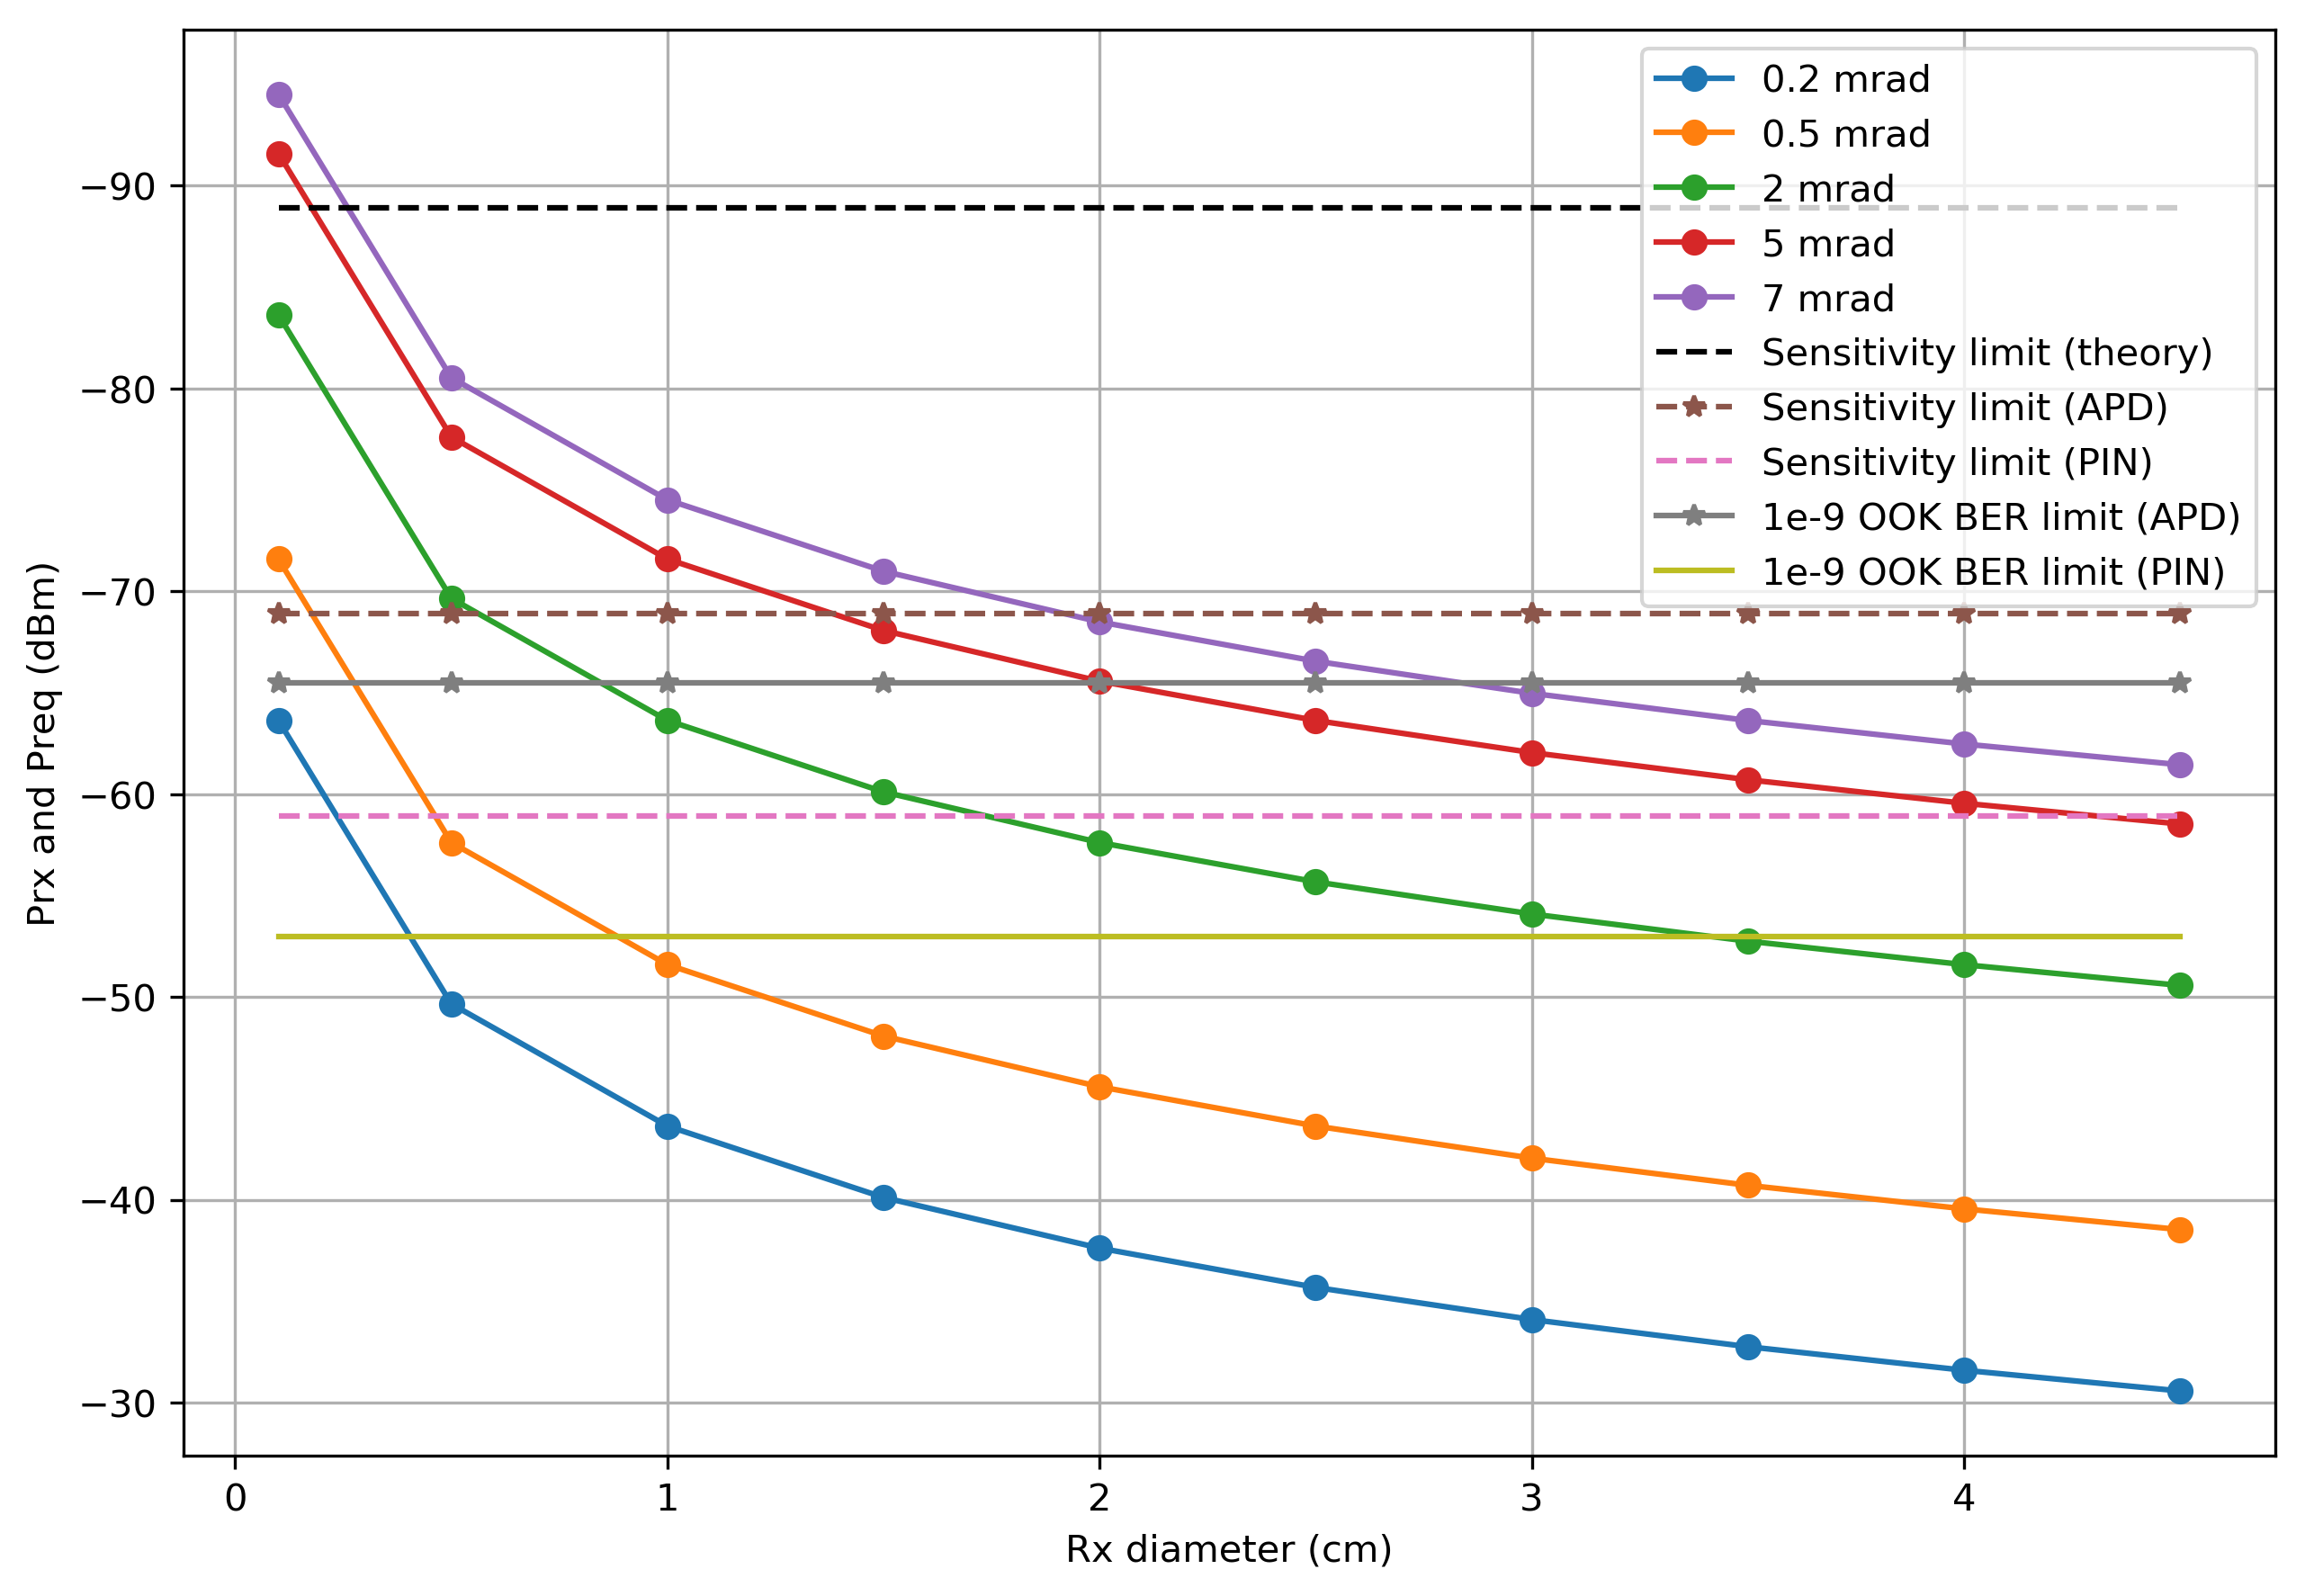

In [15]:
fig = plt.figure(figsize=(10, 7), dpi=300)

req_theor = np.ones((len(a_m),))*P_req_theor
req_real_APD = np.ones((len(a_m),))*P_req_real_APD
req_real_PIN = np.ones((len(a_m),))*P_req_real_PIN
PIN = np.ones((len(a_m),))*P_req_pin
APD = np.ones((len(a_m),))*P_req_apd

a_m = a_m.reshape((10,))

plot(a_m, Prx_opt_dBm[0,:],'-o', label = '0.2 mrad')
plot(a_m, Prx_opt_dBm[1,:],'-o', label = '0.5 mrad')
plot(a_m, Prx_opt_dBm[2,:],'-o', label = '2 mrad')
plot(a_m, Prx_opt_dBm[3,:],'-o', label = '5 mrad')
plot(a_m, Prx_opt_dBm[4,:],'-o', label = '7 mrad')
plot(a_m, req_theor,'k--', label = 'Sensitivity limit (theory)')
plot(a_m, req_real_APD, '--*', label = 'Sensitivity limit (APD)')
plot(a_m, req_real_PIN,  '--', label = 'Sensitivity limit (PIN)')
plot(a_m, APD, '-*',label = '1e-9 OOK BER limit (APD)')
plot(a_m, PIN,  label = '1e-9 OOK BER limit (PIN)')

plt.gca().invert_yaxis()
xlabel('Rx diameter (cm)'); ylabel('Prx and Preq (dBm)')
legend()
grid()
plt.show()


# Transmit power

Transmitt power (for fixed receive power):

$$ P_{tx, dBm} = P_{rx, dBm} + |L| + |L_{add}|$$

where $L = 10\log_{10}\left[ \frac{A_{rx}}{2\pi R^2}\left(1 - \frac{ln2}{ln(cos \theta_{div})}\right)\right]$ is the pass loss and $L_{add}$ is the additional losses (margin). 

In [16]:
Prx_req_dB_APD = -65.5
Prx_req_dB_PIN = -52.9

margin = 5
Arx_m2 = np.zeros((len(a)))

Ptx_variable_APD = np.zeros((len(div_ang), len(a)))
Ptx_variable_PIN = np.zeros((len(div_ang), len(a)))
#area rx
Arx_m2 = (np.pi/4)*(a**2)

for f, dvangl in enumerate(div_ang):
    #Ptx required
    Ptx_variable_APD[f,:] = Prx_req_dB_APD + np.abs(Pathloss_dBm[f,:]) + margin;
    Ptx_variable_PIN[f,:] = Prx_req_dB_PIN + np.abs(Pathloss_dBm[f,:]) + margin;

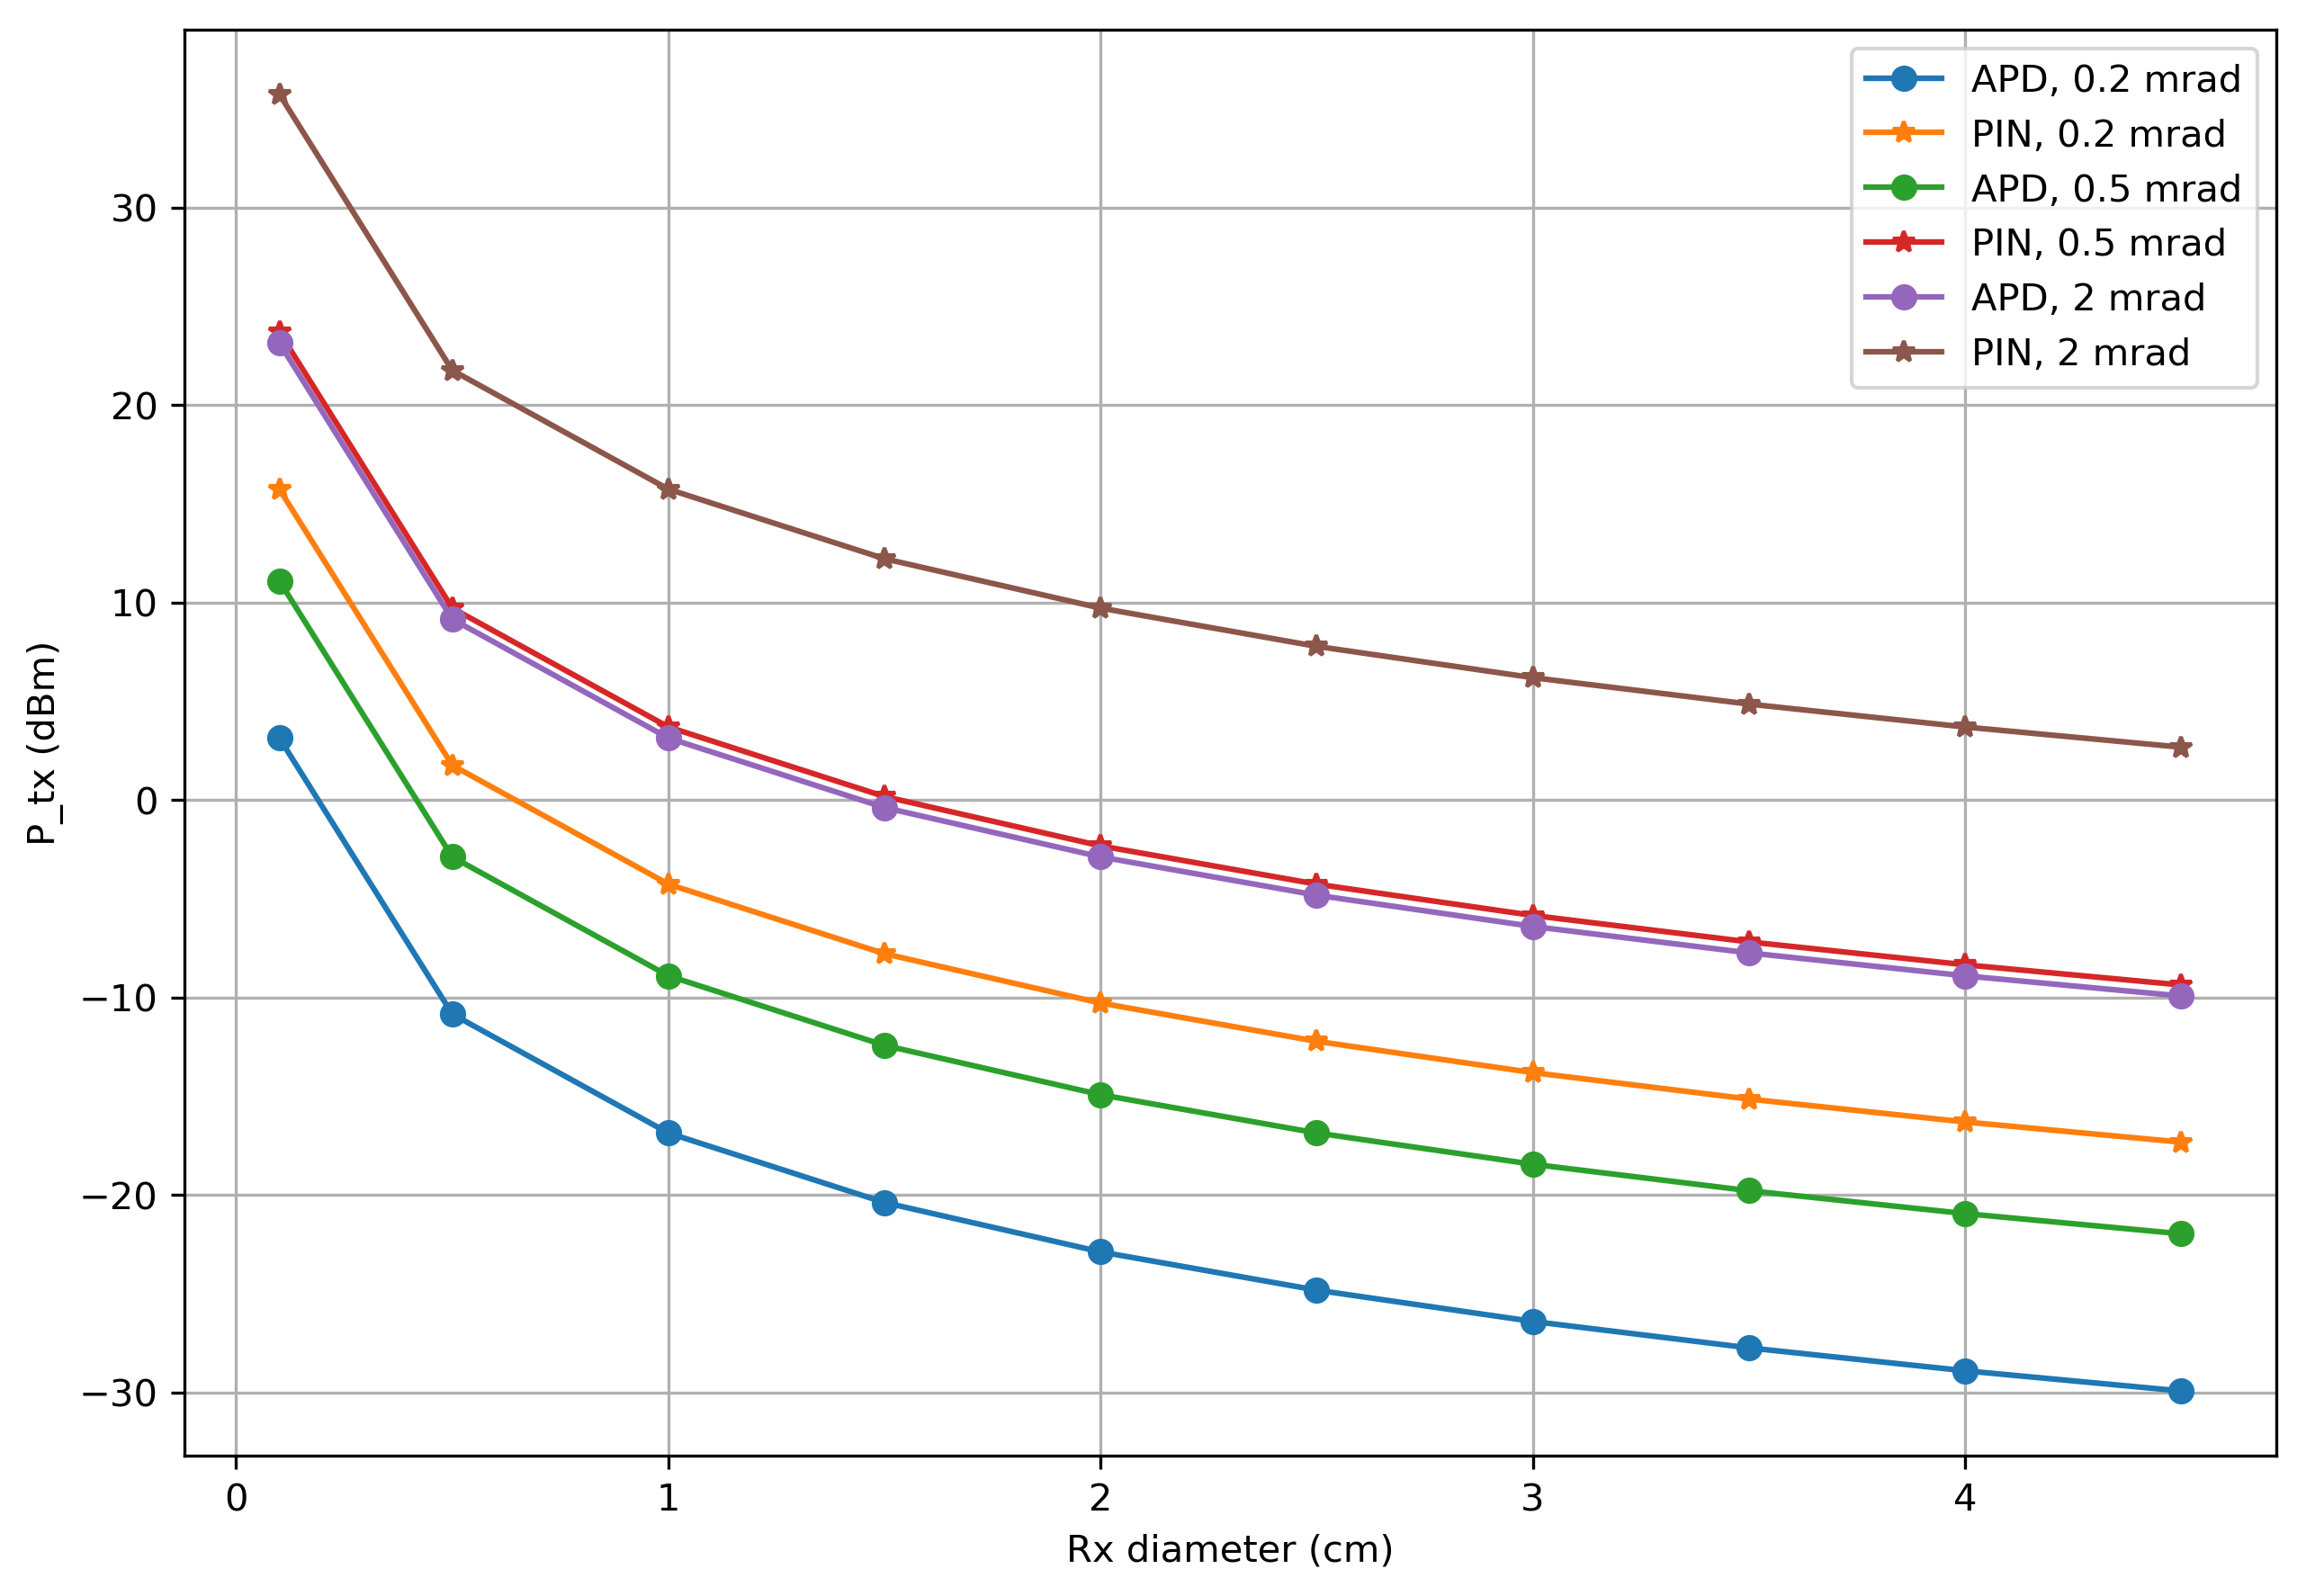

In [17]:
fig = plt.figure(figsize=(10, 7), dpi=300)


plot(a_m, Ptx_variable_APD[0,:],'-o', label = 'APD, 0.2 mrad')
plot(a_m, Ptx_variable_PIN[0,:],'-*', label = 'PIN, 0.2 mrad')
plot(a_m, Ptx_variable_APD[1,:],'-o', label = 'APD, 0.5 mrad')
plot(a_m, Ptx_variable_PIN[1,:],'-*', label = 'PIN, 0.5 mrad')
plot(a_m, Ptx_variable_APD[2,:],'-o', label = 'APD, 2 mrad')
plot(a_m, Ptx_variable_PIN[2,:],'-*', label = 'PIN, 2 mrad')

xlabel('Rx diameter (cm)'); ylabel('P_tx (dBm)')
legend()
grid()

## References

1. Wolf, M., & Kreß, D. (2003). Short-range wireless infrared transmission: the link buoget compared to RF. IEEE wireless communications, 10(2), 8-14.

2. Komine, T., & Nakagawa, M. (2004). Fundamental analysis for visible-light communication system using LED lights. IEEE transactions on Consumer Electronics, 50(1), 100-107.

3. https://www.nii.ac.jp/qis/first-quantum/forStudents/lecture/pdf/noise/chapter12.pdf